# Music classification example


This demo code extracts features from a set of songs, and then prepares this data for classification with the sklearn classifiers. The following steps are performed:

- Reading all songs from the hard disk
- Extracting several types of audio features for each song; this will be our descriptive feature
- Obtain the ground truth (target), which is implicitily encoded in the folder names of the songs

In [19]:
# We need to construct our data set; unfortunately, we don't simply have a "loadGTZanDataSet()" function in SK-learn...
# So we need to
## Download our data set & extract it (one-time effort)
## Run an audio feature extraction
## Create the create the ground truth (label assignment, target, ...)


# path to our audio folder
# For the first run, download the images from http://kronos.ifs.tuwien.ac.at/GTZANmp3_22khz.zip, and unzip them to your folder
imagePath = "../../data/GTZANmp3_22khz/"

# Find all songs in that folder; there are like 1.000 different ways to do this in Python, we chose this one :-)
import glob, os

os.chdir(imagePath)
fileNames = glob.glob("*/*.mp3")
numberOfFiles = len(fileNames)
targetLabels = []

print("Found " + str(numberOfFiles) + " files\n")

# The first step - create the ground truth (label assignment, target, ...)
# For that, iterate over the files, and obtain the class label for each file
# Basically, the class name is in the full path name, so we simply use that
for fileName in fileNames:
    pathSepIndex = fileName.index("/")
    targetLabels.append(fileName[:pathSepIndex])

# sk-learn can only handle labels in numeric format - we have them as strings though...
# Thus we use the LabelEncoder, which does a mapping to Integer numbers
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(targetLabels)  # this basically finds all unique class names, and assigns them to the numbers
print("Found the following classes: " + str(list(le.classes_)))

# now we transform our labels to integers
target = le.transform(targetLabels);
print("Transformed labels (first elements: " + str(target[0:150]))

# If we want to find again the label for an integer value, we can do something like this:
# print list(le.inverse_transform([0, 18, 1]))

print("... done label encoding")

Found 1000 files

Found the following classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Transformed labels (first elements: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
... done label encoding


Showing demo feature extraction on song ../../data/GTZANmp3_22khz/hiphop/hiphop.00057.mp3


/home/user/projects/private/fh/fh-machine-learning/venv/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/tmp/ipykernel_29545/3719292409.py:15: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.1071167  -0.1850586
 -0.28076172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_env = librosa.onset.onset_strength(y, sr=sr)


The song has [143.5546875] beats per minute


/home/user/projects/private/fh/fh-machine-learning/venv/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


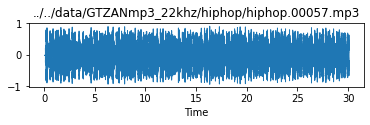

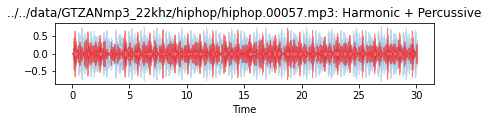

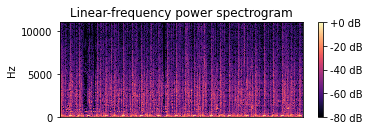

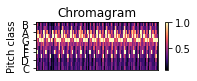

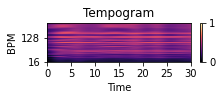

In [20]:
# Before we extract the features, let's plot some information on a demo song, to illustrate what we are doing

import matplotlib.pyplot as plt
from librosa import display
import librosa
import numpy as np

demoSongName = fileNames[1]
demoSongPath = imagePath + demoSongName
print("Showing demo feature extraction on song " + demoSongPath)

y, sr = librosa.load(demoSongPath)

# compute the tempo
onset_env = librosa.onset.onset_strength(y, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
print("The song has " + str(tempo) + " beats per minute")

# plot the wave form
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title(demoSongPath)

y_harm, y_perc = librosa.effects.hpss(y)
plt.figure()
plt.subplot(3, 1, 3)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.25)
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5)
plt.title(demoSongPath + ': Harmonic + Percussive')
plt.tight_layout()

# Plot the power spectrum
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# Plot Chroma
plt.figure()
C = librosa.feature.chroma_cqt(y=y, sr=sr)
plt.subplot(4, 2, 5)
librosa.display.specshow(C, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')

# Plot tempogram
plt.figure()
plt.subplot(4, 2, 8)
Tgram = librosa.feature.tempogram(y=y, sr=sr)
librosa.display.specshow(Tgram, x_axis='time', y_axis='tempo')
plt.colorbar()
plt.title('Tempogram')
plt.tight_layout()

plt.show()

In [21]:
# Now we do the actual feature extraction

import datetime
from collections import deque
import progressbar

import numpy as np
import scipy.stats.stats as st


# This is a helper function that computes the differences between adjacent array values
def differences(seq):
    iterable = iter(seq)
    prev = next(iterable)
    for element in iterable:
        yield element - prev
        prev = element


# This is a helper function that computes various statistical moments over a series of values, including mean, median, var, min, max, skewness and kurtosis (a total of 7 values)
def statistics(numericList):
    return [np.mean(numericList), np.median(numericList), np.var(numericList), np.float64(st.skew(numericList)),
            np.float64(st.kurtosis(numericList)), np.min(numericList), np.max(numericList)]


print("Extracting features using librosa" + " (" + str(datetime.datetime.now()) + ")")

# compute some features based on BPMs, MFCCs, Chroma
data_bpm = []
data_bpm_statistics = []
data_mfcc = []
data_chroma = []

# This takes a bit, so let's show it with a progress bar
for indexSample, fileName in enumerate(fileNames):
    # Load the audio as a waveform `y`, store the sampling rate as `sr`
    y, sr = librosa.load(fileName)

    # run the default beat tracker
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    # from this, we simply use the tempo as BPM feature
    data_bpm.append([tempo])

    # Then we compute a few statistics on the beat timings
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    # from the timings, compute the time differences between the beats
    beat_intervals = np.array(deque(differences(beat_times)))

    # And from this, take some statistics
    # There might be a few files where the beat timings are not determined properly; we ignore them, resp. give them 0 values
    if len(beat_intervals) < 1:
        print("Errors with beat interval in file " + fileName + ", index " + str(
            indexSample) + ", using 0 values instead")
        data_bpm_statistics.append([tempo, 0, 0, 0, 0, 0, 0, 0])
    else:
        bpm_statisticsVector = []
        bpm_statisticsVector.append(tempo)  # we also include the raw value of tempo
        for stat in statistics(beat_intervals):  # in case the timings are ok, we actually compute the statistics
            bpm_statisticsVector.append(stat)  # and append it to the vector, which finally has 1 + 7 features
        data_bpm_statistics.append(bpm_statisticsVector)

    # Next feature are MFCCs; we take 12 coefficients; for each coefficient, we have around 40 values per second
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)
    mfccVector = []
    for mfccCoefficient in mfccs:  # we transform this time series by taking again statistics over the values
        mfccVector.append(statistics(mfccCoefficient))

    # Finally, this vector should have 12 * 7 features
    data_mfcc.append(np.array(mfccVector).flatten())

    # Last feature set - chroma (which is roughly similar to actual notes)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr);
    chromaVector = []
    for chr in chroma:  # similar to before, we get a number of time-series
        chromaVector.append(statistics(chr))  # and we resolve that by taking statistics over the time series
    # Finally, this vector should be be 12 * 7 features
    data_chroma.append(np.array(chromaVector).flatten())

print(".... done" + " (" + str(datetime.datetime.now()) + ")")

Extracting features using librosa (2022-05-25 17:24:37.065569)


/home/user/projects/private/fh/fh-machine-learning/venv/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/tmp/ipykernel_29545/830103153.py:22: DeprecationWarning: Please use `skew` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  return [np.mean(numericList), np.median(numericList), np.var(numericList), np.float64(st.skew(numericList)),
/tmp/ipykernel_29545/830103153.py:23: DeprecationWarning: Please use `kurtosis` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  np.float64(st.kurtosis(numericList)), np.min(numericList), np.max(numericList)]
/home/user/projects/private/fh/fh-machine-learning/venv/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/tmp/ipykernel_29545/830103153.py:22: DeprecationWarning: Please use `skew` from 

Errors with beat interval in file classical/classical.00050.mp3, index 115, using 0 values instead


/tmp/ipykernel_29545/830103153.py:22: DeprecationWarning: Please use `skew` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  return [np.mean(numericList), np.median(numericList), np.var(numericList), np.float64(st.skew(numericList)),
/tmp/ipykernel_29545/830103153.py:23: DeprecationWarning: Please use `kurtosis` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  np.float64(st.kurtosis(numericList)), np.min(numericList), np.max(numericList)]
/home/user/projects/private/fh/fh-machine-learning/venv/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/tmp/ipykernel_29545/830103153.py:22: DeprecationWarning: Please use `skew` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  return [np.mean(numericList), np.median(numericList), np.var(numericList), np.float64(st.skew(numericList)),
/tmp/ipykerne

.... done (2022-05-25 17:35:15.787468)


/tmp/ipykernel_29545/830103153.py:22: DeprecationWarning: Please use `skew` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  return [np.mean(numericList), np.median(numericList), np.var(numericList), np.float64(st.skew(numericList)),
/tmp/ipykernel_29545/830103153.py:23: DeprecationWarning: Please use `kurtosis` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  np.float64(st.kurtosis(numericList)), np.min(numericList), np.max(numericList)]


In [22]:
# Finally, we do classification

# These are our feature sets; we will use each of them individually to train classifiers
trainingSets = [data_bpm, data_bpm_statistics, data_chroma, data_mfcc]

from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import tree
from sklearn import ensemble
from sklearn import svm

# set up a number of classifiers
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.GaussianNB(),
               tree.DecisionTreeClassifier(),
               ensemble.RandomForestClassifier(),
               svm.SVC(),
               svm.LinearSVC(),
               ]

for indexDataset, train in enumerate(trainingSets):
    for indexClassifier, classifier in enumerate(classifiers):
        # do the actual classification
        print("Classifying ...")

Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
Classifying ...
